# **Multiclass Classification**
> ❗ **Recall**

> This is a multiclass classification problem since it involves classifying more than 2 classes
+ In our case, we'll be classifying `22` different crop classes, as seen in the previous notebook

## Loading the data
> We always have to start from here, don't we.
+ Load the data
+ Prepare the data for training and validation


In [ ]:
# import pandas, matplotlib, seaborn
import pandas as pd
import matplotlib.pyplot as plt

# specify style sheet
plt.style.use('fast')

In [ ]:
# load dataset
crops = pd.read_csv('/content/crop_recommendation.csv')

# dataset info
crops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nitrogen     2200 non-null   int64  
 1   phosphorus   2200 non-null   int64  
 2   potassium    2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [ ]:
# capitalize the first letter of every value in 'label'
crops['label'] = crops['label'].apply(lambda x: x.capitalize())

In [ ]:
# print to confirm
crops.label.unique()

array(['Rice', 'Maize', 'Chickpea', 'Kidneybeans', 'Pigeonpeas',
       'Mothbeans', 'Mungbean', 'Blackgram', 'Lentil', 'Pomegranate',
       'Banana', 'Mango', 'Grapes', 'Watermelon', 'Muskmelon', 'Apple',
       'Orange', 'Papaya', 'Coconut', 'Cotton', 'Jute', 'Coffee'],
      dtype=object)

In [ ]:
# split the dataset into features and label
# features
X = crops[crops.columns[:-1]].values

# label
y = crops['label'].values

In [ ]:
from sklearn.model_selection import train_test_split

# split dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.3, random_state=42)

In [ ]:
# specify indices of numeric columns (for preprocessing)
num_col_indices = list(range(0,7))

# confirm
print(num_col_indices)

[0, 1, 2, 3, 4, 5, 6]


## Data preprocessing `pipeline`
> Here, we'll make a data pre-processing pipeline using [`scikit-learn's`](https://scikit-learn.org/stable/index.html) [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) and [`make_colum_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html)
+ Other classes we'll use are [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#simpleimputer) to handle missing values and [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to scale numerical features
+ Note that all features in our dataset are numerical in nature, hence we won't be _encoding_ any features. Just _scaling_

In [ ]:
# imports necessary classes
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [ ]:
# numeric transformer
num_transformer = make_pipeline(
    # list of transformer objects
    SimpleImputer(strategy='median'), # handle nulls, if any
    StandardScaler() # scale features
)

# wrap the numeric transformer in a column_transformer
preprocesser = make_column_transformer(
    #(transformer, columns)
    (num_transformer, num_col_indices)
)

## Modelling
> We'll be using the [`CatBoostClassifier`](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier) from the [`CatBoost`](https://catboost.ai/en/docs/) library

In [ ]:
# install catboost
!pip install catboost

In [ ]:
# imports
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline

### Train a [`CatBoostClassifier`]() model
> ✋ **Disclaimer**
+ We aren't going to perform hyperparameter tuning with this model, since as already established in the previous notebook, the dataset is quite simple and linearly separable - we wouldn't want to risk overfitting. Also, [`CatBoost`](https://catboost.ai/en/docs/) is really good, right out of the box.
+ We'll set an overfitting detector using `CatBoostClassifier` `early_stopping_rounds` & `eval_metric` parameters, then we'll pass an `eval_set` to the `fit` method during training

In [ ]:
%%time
# set up pipeline with preprocesser + estimator
cat_model = Pipeline(steps=[
    #(name, tranform)
    ('preprocess', preprocesser),
    ('cbc', CatBoostClassifier(iterations=100,
                               random_state=42,
                               early_stopping_rounds=20,
                               eval_metric='TotalF1'))
])

# train model
cat_model.fit(X_train, y_train,
              cbc__verbose=5,
              cbc__eval_set=[
                (preprocesser.fit_transform(X_test), y_test), # evaluation set
              ])
print('')

Learning rate set to 0.262469
0:	learn: 0.6066769	test: 0.6084669	best: 0.6084669 (0)	total: 36.6ms	remaining: 3.62s
5:	learn: 0.9739108	test: 0.9651865	best: 0.9651865 (5)	total: 163ms	remaining: 2.55s
10:	learn: 0.9869832	test: 0.9787992	best: 0.9788195 (7)	total: 301ms	remaining: 2.43s
15:	learn: 0.9915506	test: 0.9803815	best: 0.9804006 (12)	total: 431ms	remaining: 2.26s
20:	learn: 0.9921981	test: 0.9894053	best: 0.9894053 (20)	total: 577ms	remaining: 2.17s
25:	learn: 0.9941500	test: 0.9924360	best: 0.9924360 (23)	total: 709ms	remaining: 2.02s
30:	learn: 0.9947989	test: 0.9939592	best: 0.9939592 (30)	total: 838ms	remaining: 1.87s
35:	learn: 0.9960982	test: 0.9939592	best: 0.9939592 (30)	total: 967ms	remaining: 1.72s
40:	learn: 0.9987012	test: 0.9954773	best: 0.9954773 (40)	total: 1.1s	remaining: 1.58s
45:	learn: 0.9993506	test: 0.9969689	best: 0.9969689 (44)	total: 1.23s	remaining: 1.44s
50:	learn: 0.9993506	test: 0.9969689	best: 0.9969689 (44)	total: 1.39s	remaining: 1.33s
55:	lea

### Plot the training and evaluation scores
> We can access the evaluation results from the trained model using the `CatBoostClassifier` attribute, `evals_results_`
+ Plot training and evaluation scores against number of boosted trees / interations


In [ ]:
# get the keys from the evaluation results dictionary
cat_model.named_steps['cbc'].evals_result_.keys()

dict_keys(['learn', 'validation'])

In [ ]:
# get training scores
train_scores = cat_model.named_steps['cbc'].evals_result_['learn']['TotalF1']

# get validation scores
test_scores = cat_model.named_steps['cbc'].evals_result_['validation']['TotalF1']

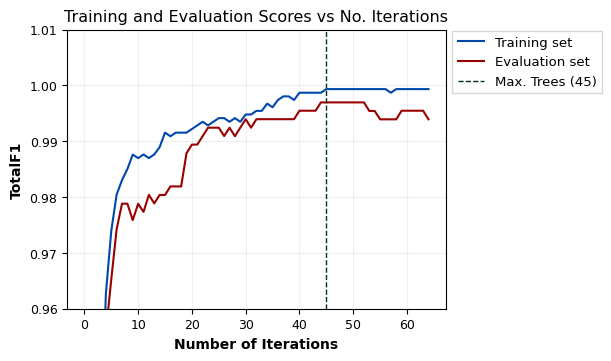

In [ ]:
# plot both scores on a line graph
_, ax = plt.subplots(figsize=(6,3.5), layout='constrained')

# plot 1
ax.plot(train_scores, label='Training set', linewidth=1.5, color='#0047ab')
# plot 2
ax.plot(test_scores, label='Evaluation set', linewidth=1.5, color='#990000')

# title, axis labels, grid, legend
ax.set_title('Training and Evaluation Scores vs No. Iterations',
             fontsize=11.5)
ax.set_ylabel('TotalF1', weight='black')
ax.set_xlabel('Number of Iterations', weight='black')
ax.grid(axis='both', alpha=0.2)
ax.tick_params(axis='both', labelsize=9)
# zoom in on the plot
ax.set_ylim(0.96, 1.01)

# draw a vertical line at the point where maximum trees were achieved
max_trees = cat_model.named_steps['cbc'].tree_count_
ax.axvline(x=max_trees, color='#013220',
          linestyle='--', linewidth=1,
           label=f'Max. Trees ({max_trees})')

ax.legend(fancybox=False, loc='upper left',
          bbox_to_anchor=(1.0, 1.02),
          fontsize=9.5)

plt.show()

> 💡 **Insight**

> The line plot monitors the progression of `TotalF1` (note that this is a metric specific to the `CatBoost` library) during the model training process
+ When evaluated on both the training and evaluation sets, the `TotalF1` increases with the number of boosting rounds until a point of _convergence_ (`45` boosting trees)
+ Beyond that, the model's performance on data it has never 'seen' and wasn't trained on (_evaluation set_) starts to plateau, then decrease. And as the trend illustrates, it would have gotten worse, signifying high variance error (due to _overfitting_)
+ Thanks to the overfitting detector we set up, the training was stopped once the model converged with reference to the metric we specified (`TotalF1`)

### Make predictions
> Derive predictions from the trained model, usually by passing the `X_test` dataset

In [ ]:
y_pred = cat_model.predict(X_test)

## Evaluation
> Time to see how well the model performed

In [ ]:
# imports
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
# define function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred):
  # specify Axes
  _, ax = plt.subplots(figsize=(6.5,6.5), layout='constrained')

  # plot matrix
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                          cmap='Blues',
                                          colorbar=False,
                                          text_kw={'fontsize':9},
                                          ax=ax)

  # move xticks and xlabel to top
  ax.xaxis.tick_top()
  ax.xaxis.set_label_position('top')

  # modify xlabel and ylabel colors
  ax.set_ylabel('Actual Labels', weight='black', color='#003262', fontsize=11)
  ax.set_xlabel('Predicted Labels', weight='black', color='#E52B50', fontsize=11)
  ax.tick_params(axis='x', labelrotation=90, labelsize=9)
  ax.tick_params(axis='y', labelsize=9)

  plt.show()

In [ ]:
# define function to plot multiclass ROC curve (OVR approach)
def plot_multiclass_roc_curve(model, X_test, y_test):
  # list of crops
  crop_list = crops['label'].unique()

  # get prediction probabilities
  y_proba = model.predict_proba(X_test)

  # binarize y_test (y_true)
  y_test_bin = label_binarize(y_test, classes=crop_list)

  # specify Axes
  _, ax = plt.subplots(figsize=(7.5,4.5), layout='constrained')

  for i in range(len(crop_list)):
    # return fpr, tpr, thresholds
    fpr, tpr, _ = roc_curve(y_true=y_test_bin[:, i] , y_score=y_proba[:, i])

    # calculate auc for this instance
    area = auc(fpr, tpr)

    # plot ROC curve: yaxis=tpr, xaxis=fpr
    ax.plot(fpr, tpr, linestyle='--', linewidth=1.7,
            label=f'{crop_list[i]} vs Rest (AUC = {round(area, 2)})')

  # title, axis labels, legend
  ax.set_title('Multiclass ROC Curve (OvR)', fontsize=10.5, weight='black')
  ax.set_ylabel('True Positive Rate')
  ax.set_xlabel('False Positive Rate')
  ax.legend(fancybox=False, loc='upper left',
            bbox_to_anchor=(1.0, 1.02),
            fontsize=9)

  plt.show()

### Visualize `confusion_matrix` using [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)
> The confusion matrix shows where the model errs, as well as where the model gets predictions right

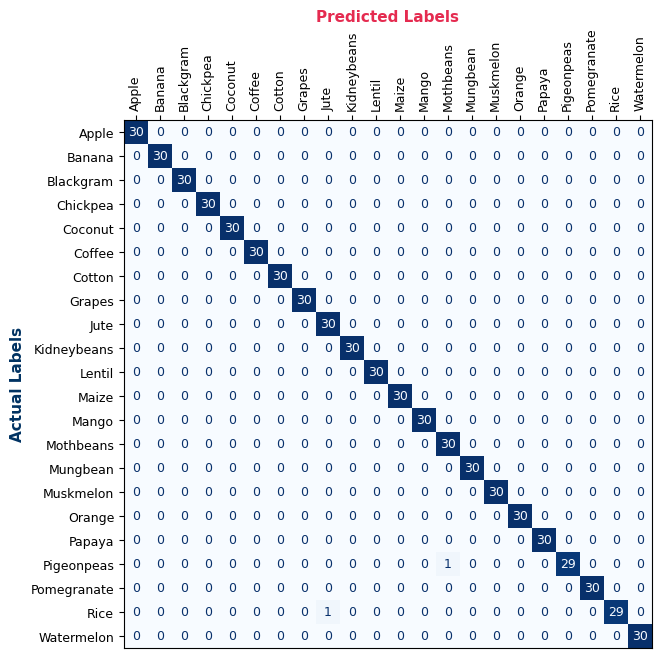

In [ ]:
plot_confusion_matrix(y_test, y_pred)

### [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)


In [ ]:
# print
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        30
      Banana       1.00      1.00      1.00        30
   Blackgram       1.00      1.00      1.00        30
    Chickpea       1.00      1.00      1.00        30
     Coconut       1.00      1.00      1.00        30
      Coffee       1.00      1.00      1.00        30
      Cotton       1.00      1.00      1.00        30
      Grapes       1.00      1.00      1.00        30
        Jute       0.97      1.00      0.98        30
 Kidneybeans       1.00      1.00      1.00        30
      Lentil       1.00      1.00      1.00        30
       Maize       1.00      1.00      1.00        30
       Mango       1.00      1.00      1.00        30
   Mothbeans       0.97      1.00      0.98        30
    Mungbean       1.00      1.00      1.00        30
   Muskmelon       1.00      1.00      1.00        30
      Orange       1.00      1.00      1.00        30
      Papaya       1.00    

> 👏 **Bam!**

> From the confusion matrix and classification report, the model is doing really well at distinguishing between classes. Not bad, not bad!

### `roc` curve (OvR Multiclass approach)

> 🔢 **Multiclass classification (OvR)**  

> In a multiclass classification problem using the _One-vs-Rest_ (OvR) approach for plotting `ROC` curves, we handle each class as the positive class, `1` in turn, and treat all the other classes collectively as negative, `0`
> Therefore, in a multiclass classification problem using the One-vs-Rest (OvR) approach for plotting `ROC` curves, we handle each class as the positive class, `1` in turn, and treat all the other classes collectively as negative, `0`
+ Get probability estimates for each class
+ Convert true labels into a binary format suitable for `ROC` curve computation (using [`scikit-learn's`](https://scikit-learn.org/stable/index.html) [`label_binarize`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize.html) method)
+ Compute False Positive Rates; `fpr` and True Positive Rates; `tpr` for each class.
+ Calculate the ROC AUC score for each class

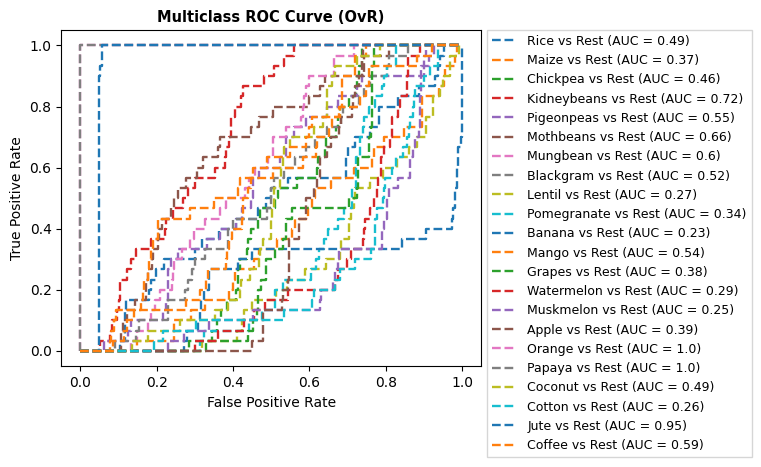

In [ ]:
plot_multiclass_roc_curve(cat_model, X_test, y_test)

> ✋ **Disclaimer**

> The Area Under Curve `(AUC)` metric is sensitive to the ranking of positive and negative instances.
+ As the number of classes increases (such as 22 in our case) in an OVR approach, the chances of incorrect rankings increase, leading to a decrease in `AUC`
+ Hence, in this case, the `AUC` for each individual class would not be the best metric of evaluation 💔
+ The plot looks gorgeous though, with all those beautiful lines and whatnot, wouldn't you agree? 😺😺😺

### Overall [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
> Instead of taking the OVR approach, we'll summarize the mode's _overall_ ability to distinguish between classes
+ Therefore, we'll use the [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) on the entire model

In [ ]:
ov_auc = roc_auc_score(y_test, cat_model.predict_proba(X_test),
              multi_class='ovr')

# print
print(f'Overall AUC: {ov_auc}')

Overall AUC: 0.99999518999519


> 📝 **Takeaway**

> So how did the model perform in classifying unseen data into respective crop classes?
+ Weighted & macro [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) : `1.00`
+ Weighted & macro [`recall_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score) : `1.00`
+ Weighted & macro [`precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score) : `1.00`
+ Overall [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) : `0.99`
+ Overall [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) : `1.00`

> Given that all these metrics are on a scale of `0.0` to `1.0` we really can trust the model with making predictions.

## Model persistence

#### Saving the model
> The model has been saved in the `model` folder of the current repository as `crop_recommendation_model.pkl`

In [ ]:
import joblib

filename = 'crop_recommendation_model.pkl'

# dump
joblib.dump(value=cat_model, filename=filename)

['crop_recommendation_model.pkl']